In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
delim = ';'

base_path = '/opt/iui-datarelease1-sose2021/'

Xpickle_file = '../X2.pickle'

ypickle_file = '../y2.pickle'

In [3]:
THRESH = 0.1
LEEWAY = 1
EPOCH = 20

DENSE_COUNT = 2
DENSE_NEURONS = 1000

DENSE2_COUNT = 2
DENSE2_NEURONS = 600

AVG_FROM = 10

In [4]:
def plot_pd(data):
    fig, axs = plt.subplots(4, 3, figsize=(3*3, 3*4))
    t = data['Millis']
    axs[0][0].plot(t, data['Acc1 X'])
    axs[0][1].plot(t, data['Acc1 Y'])
    axs[0][2].plot(t, data['Acc1 Z'])
    axs[1][0].plot(t, data['Acc2 X'])
    axs[1][1].plot(t, data['Acc2 Y'])
    axs[1][2].plot(t, data['Acc2 Z'])
    axs[2][0].plot(t, data['Gyro X'])
    axs[2][1].plot(t, data['Gyro Y'])
    axs[2][2].plot(t, data['Gyro Z'])
    axs[3][0].plot(t, data['Mag X'])
    axs[3][1].plot(t, data['Mag Y'])
    axs[3][2].plot(t, data['Mag Z'])

    for a in axs:
        for b in a:
            b.plot(t, data['Force'])


In [5]:
def plot_data(data):
    fig, axs = plt.subplots(4, 3, figsize=(3*3, 3*4))
    axs[0][0].plot(data[1])
    axs[0][1].plot(data[2])
    axs[0][2].plot(data[3])
    axs[1][0].plot(data[4])
    axs[1][1].plot(data[5])
    axs[1][2].plot(data[6])
    axs[2][0].plot(data[7])
    axs[2][1].plot(data[8])
    axs[2][2].plot(data[9])
    axs[3][0].plot(data[10])
    axs[3][1].plot(data[11])
    axs[3][2].plot(data[12])

    for a in axs:
        for b in a:
            b.plot(data[13])


In [6]:
import pickle

def load_pickles():
    _p = open(Xpickle_file, 'rb')
    X = pickle.load(_p)
    _p.close()
        
    _p = open(ypickle_file, 'rb')
    y = pickle.load(_p)
    _p.close()
    
    return (np.asarray(X, dtype=pd.DataFrame), np.asarray(y, dtype=str))

In [7]:
import os

def load_data():
    if os.path.isfile(Xpickle_file) and os.path.isfile(ypickle_file):
        return load_pickles()
    data = []
    label = []
    for user in range(0, user_count):
        user_path = base_path + str(user) + '/split_letters_csv/'
        for file in os.listdir(user_path):
            file_name = user_path + file
            letter = ''.join(filter(lambda x: x.isalpha(), file))[0]
            data.append(pd.read_csv(file_name, delim))
            label.append(letter)
    return (np.asarray(data, dtype=pd.DataFrame), np.asarray(label, dtype=str), np.asarray(file_name))

In [8]:
%%time
X, y = load_data()

X.shape

CPU times: user 5.38 s, sys: 398 ms, total: 5.78 s
Wall time: 5.78 s


(26179,)

In [9]:
def shorten(npList, thresh):
    temp        = npList['Force']
    thresh      = temp.max()*thresh
    leeway      = LEEWAY
    
    temps_over_T = np.where(temp > thresh)[0]
    return npList[max(temps_over_T[0]-leeway,0):min(len(npList)-1,temps_over_T[-1]+leeway)].to_numpy()

In [10]:
%%time

XX = np.array(list(map(shorten, X, [THRESH for _ in range(len(X))])),dtype=object)

CPU times: user 6.94 s, sys: 72.8 ms, total: 7.01 s
Wall time: 6.98 s


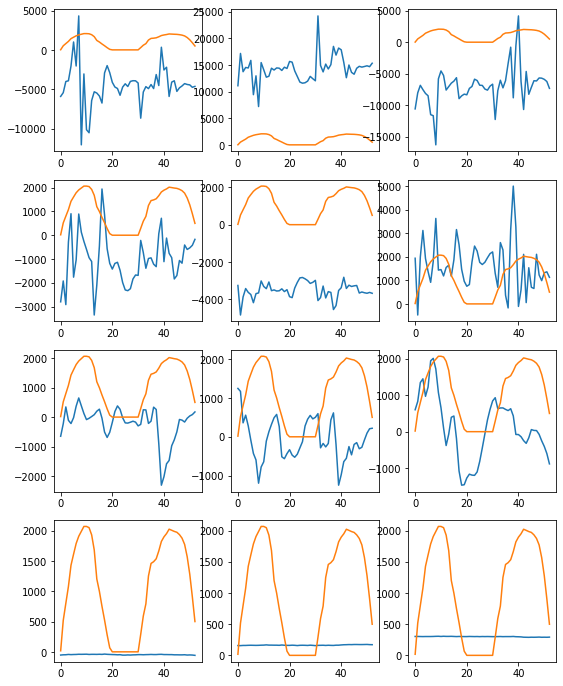

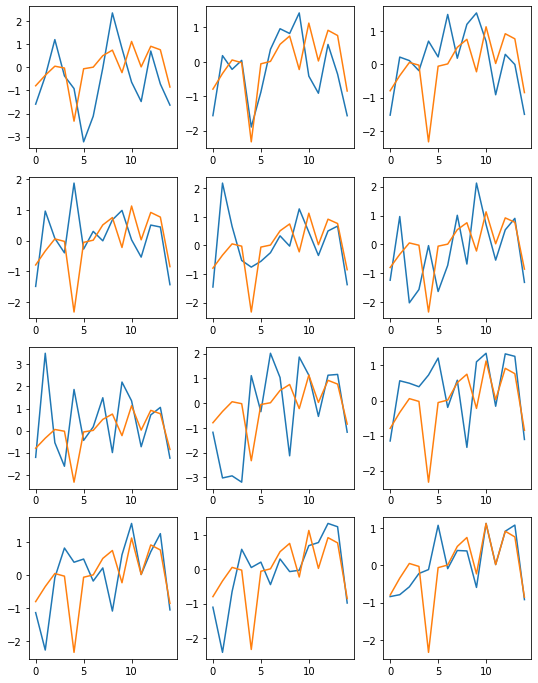

In [11]:
from sklearn.preprocessing import RobustScaler, MaxAbsScaler, MinMaxScaler, StandardScaler
scaler = StandardScaler()
data = XX[0]
plot_data(data.T)

plot_data(scaler.fit_transform(data))

In [12]:
XXX = np.array(list(map(scaler.fit_transform, XX)),dtype=object)

count    26179.000000
mean        48.405172
std         30.709627
min          6.000000
50%         44.000000
90%         72.000000
91%         74.000000
92%         76.000000
93%         79.000000
94%         82.000000
95%         87.000000
96%         91.000000
97%         98.000000
98%        109.000000
99%        137.000000
max       1718.000000
dtype: float64

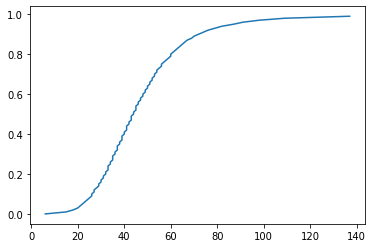

In [13]:
X_len = np.asarray(list(map(len, XX)))
l = []
sq_xlen = pd.Series(X_len)
ptiles = [x*0.01 for x in range(100)]
for i in ptiles:
    l.append(sq_xlen.quantile(i))
plt.plot(l, ptiles)
sq_xlen.describe(percentiles=[x*0.01 for x in range(90,100)])

In [14]:
threshold_p = 0.99
len_mask = np.where(np.asarray(list(map(len, XX))) <= int(pd.Series(np.asarray(list(map(len, XXX)))).quantile(threshold_p)))

X_filter = XX[len_mask]
y_filter = y[len_mask]

X_filter.shape, X_filter[0].shape

((25918,), (53, 15))

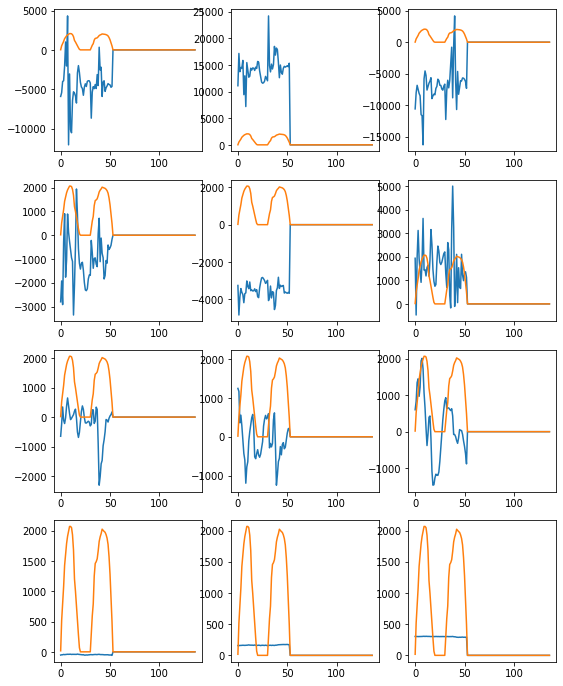

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_filter = pad_sequences(X_filter, dtype=float, padding='post')

plot_data(X_filter[0].T)

In [16]:
X_filter = np.array([np.delete(x, 0, 1) for x in X_filter])
X_filter.shape

(25918, 137, 14)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import tensorflow as tf

lb = LabelBinarizer()

yt_filter = lb.fit_transform(y_filter)

X_train, X_test, y_train, y_test = train_test_split(X_filter, yt_filter, test_size=0.2, random_state=177013)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(20734, 137, 14)
(5184, 137, 14)
(20734, 52)
(5184, 52)


In [18]:
# import os

# # By users on card, could do by memory, but too lazy
# def get_least_used_gpu():
#     a = [x.split('|') for x in os.popen('gpustat').read().split('\n')[1:-1]]
#     lu = min([x[-1].split() for x in a], key=len)
#     lui = [i for i in range(len(a)) if a[i][3] == ''.join(lu)][0]
#     print(f'Using {a[lui][0]}')
#     return lui
    
# lu_gpu = get_least_used_gpu()

In [19]:
# FIRST CELL: set these variables to limit GPU usage.
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'  # this is required
os.environ['CUDA_VISIBLE_DEVICES'] = '2'       # set to '0' for GPU0, '1' for GPU1 or '2' for GPU2. Check "gpustat" in a terminal.

In [20]:
accs = []

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tqdm import tqdm


def build_model():
    model = Sequential()
    
    model.add(BatchNormalization(input_shape=X_filter[0].shape))
    model.add(Dropout(0.2))
        
    
    model.add(Flatten( ))

    for i in range(DENSE_COUNT):
        model.add(Dense(DENSE_NEURONS, activation='relu'))
        
    for i in range(DENSE2_COUNT):
        model.add(Dense(DENSE2_NEURONS, activation='relu'))
    model.add(Dropout(0.2))
        
    
    model.add(Dense(52, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss="categorical_crossentropy", 
        metrics=["acc"],
    )

    return model
#     model.summary()


In [22]:
for i in tqdm(range(1)):
    model = build_model()
    
    model.fit(X_train, y_train, 
              epochs=EPOCH,
              batch_size=256,
              shuffle=True,
              validation_data=(X_test, y_test),
              verbose=1,
             )
    # Evaluate the model on the test data using `evaluate`
#     print("Evaluate on test data")
    results = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
    print("test loss, test acc:", results)
    accs.append((model,results[1]))
    model.summary()

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/20
81/81 [==============================] - 1s 6ms/step - loss: 3.1932 - acc: 0.1521 - val_loss: 2.4668 - val_acc: 0.3038
Epoch 2/20
81/81 [==============================] - 0s 4ms/step - loss: 2.1157 - acc: 0.3769 - val_loss: 1.7419 - val_acc: 0.4670
Epoch 3/20
81/81 [==============================] - 0s 4ms/step - loss: 1.6080 - acc: 0.4976 - val_loss: 1.4454 - val_acc: 0.5484
Epoch 4/20
81/81 [==============================] - 0s 4ms/step - loss: 1.3078 - acc: 0.5800 - val_loss: 1.3221 - val_acc: 0.5799
Epoch 5/20
81/81 [==============================] - 0s 4ms/step - loss: 1.1233 - acc: 0.6282 - val_loss: 1.2188 - val_acc: 0.6173
Epoch 6/20
81/81 [==============================] - 0s 4ms/step - loss: 0.9627 - acc: 0.6661 - val_loss: 1.1781 - val_acc: 0.6296
Epoch 7/20
81/81 [==============================] - 0s 4ms/step - loss: 0.8519 - acc: 0.7032 - val_loss: 1.1871 - val_acc: 0.6354
Epoch 8/20
81/81 [==============================] - 0s 4ms/step - loss: 0.7557 - acc: 0.73

100%|██████████| 1/1 [00:08<00:00,  8.67s/it]

test loss, test acc: [1.383405089378357, 0.6608796119689941]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 137, 14)           56        
_________________________________________________________________
dropout (Dropout)            (None, 137, 14)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1918)              0         
_________________________________________________________________
dense (Dense)                (None, 1000)              1919000   
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_2 (Dense)              (None, 600)               600600    
_____________________________________________________________

In [23]:
np.mean(np.delete(accs,0,1).astype('float64'))

0.6608796119689941

In [24]:
exit()